In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory
from ocpa.objects.log.exporter.ocel import factory as ocel_export_factory
from src.helpers.dataset import get_selected_dataset, log_path_for_dataset
from src.data.convert import df_to_ocel
from definitions import ROOT_DIR

In [3]:
dataset = get_selected_dataset()
visualization_path = os.path.join(ROOT_DIR, 'reports', dataset['filename'])
ocel = ocel_import_factory.apply(log_path_for_dataset(dataset))

In [4]:
# Get the top 10 most frequent variants
top_variants = sorted(ocel.variants_dict.items(), key=lambda x: len(x[1]), reverse=True)[:12]
# Print the top 10 variants with their frequency
pid_amount = len(ocel.process_executions)
for variant, pids in top_variants:
    print(f'{variant} - {len(pids)} ({len(pids) / pid_amount * 100:.2f}%)')
# Total amount of top variants
print(f'Total amount of top variants: {sum([len(pids) for _, pids in top_variants])}')

f1c25cbfdfe557c69a3bb3f9e42e4a3b - 15 (31.25%)
e4e64b37eb1f8630c30a52929915220a - 7 (14.58%)
b5bea0f480eef15be9faebd77c4ce2ad - 7 (14.58%)
b7fe50bc12d7cc0037265eeef19786a0 - 6 (12.50%)
ced9381e5ba90f25b6489d0af0d4e431 - 3 (6.25%)
5612d835e29bdf86df3ac5d7bd2e48f1 - 2 (4.17%)
5479da620fa4328191220709ec517b3b - 2 (4.17%)
edd415935c5d0aa0171ea1029949ffb6 - 2 (4.17%)
719236f225f38f0775d66ee24c52a471 - 1 (2.08%)
e1116cdc4745967501449ebb0d1f2f4a - 1 (2.08%)
87f89afef94c61aa0e108afecbef4376 - 1 (2.08%)
27ee43072ec2ed20a3680585e5196fb4 - 1 (2.08%)
Total amount of top variants: 48


In [5]:
# Check if the event times are equal for the second and third most frequent variant
# The variants are equal except for the order of the events
# Therefore we investigate if the events occur at the same time or if this order really appears in the data
for variant in top_variants[1:3]:
    # Check for each process execution of the variant if the events occur at the same time
    equal_times_counter = 0
    for pid in variant[1]:
        # Get the event ids of the process execution
        event_ids = ocel.process_executions[pid]
        # Get the events of the process execution
        events = ocel.log.log.loc[ocel.log.log['event_id'].isin(event_ids)]
        # Get the event times of the events
        event_times = events['event_timestamp'].tolist()[:2]
        # Check if the event times are equal
        if event_times[0] == event_times[1]:
            equal_times_counter += 1
    print(f'For variant {variant[0]} the event times are equal for {equal_times_counter} out of {len(variant[1])} process executions')

For variant e4e64b37eb1f8630c30a52929915220a the event times are equal for 0 out of 7 process executions
For variant b5bea0f480eef15be9faebd77c4ce2ad the event times are equal for 0 out of 7 process executions


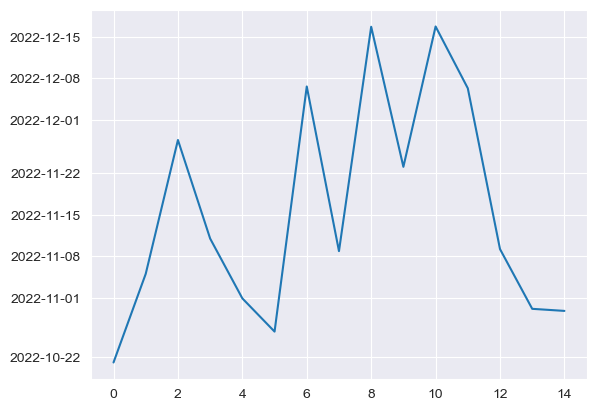

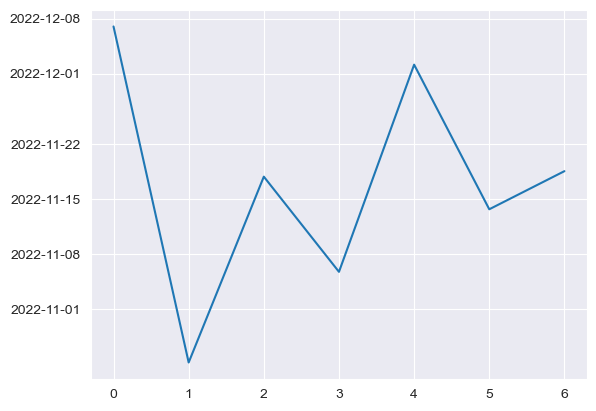

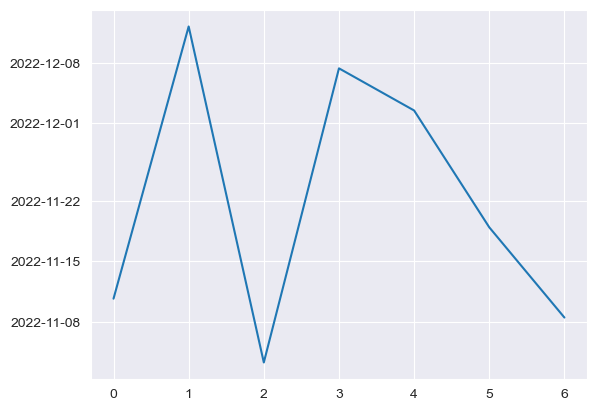

In [6]:
# Check if the first three variants are truncated by the time window of the log
# or if the variants are really that short (data quality issue)
for variant in top_variants[:3]:
    timestamps = []
    for pid in variant[1]:
        # Get the event ids of the process execution
        event_ids = ocel.process_executions[pid]
        # Get the last time of the events
        last_time = ocel.log.log.loc[ocel.log.log['event_id'].isin(event_ids)]['event_timestamp'].max()
        timestamps.append(last_time)
    # Plot the timestamps
    import matplotlib.pyplot as plt
    plt.plot(timestamps)
    plt.show()

In [7]:
# For each variant, get the set of event ids of one of the process executions
event_ids = set()
for variant in top_variants:
    pid = variant[1][0]
    print(f'Adding the event ids {ocel.process_executions[pid]} of process execution {pid} for variant {variant[0]}')
    event_ids = event_ids | ocel.process_executions[pid]

Adding the event ids {0, 1, 2, 3, 4, 160, 360, 140, 25} of process execution 33 for variant f1c25cbfdfe557c69a3bb3f9e42e4a3b
Adding the event ids {2241, 70, 71, 72, 73, 74, 75, 76, 1328, 1329, 2233, 1338, 2237} of process execution 13 for variant e4e64b37eb1f8630c30a52929915220a
Adding the event ids {231, 1994, 1995, 1997, 206, 207, 208, 209, 210, 1365} of process execution 26 for variant b5bea0f480eef15be9faebd77c4ce2ad
Adding the event ids {1312, 1313, 1319, 2056, 2059, 2062, 18, 19, 20, 21, 22, 23, 24, 1310} of process execution 7 for variant b7fe50bc12d7cc0037265eeef19786a0
Adding the event ids {1921, 1922, 1924, 1318, 11, 12, 13, 14, 15, 16, 17, 1714, 1308, 1309, 1311} of process execution 4 for variant ced9381e5ba90f25b6489d0af0d4e431
Adding the event ids {1828, 198, 1800, 1932, 174, 175, 176, 177, 178, 1360, 1934, 1938, 1727} of process execution 14 for variant 5612d835e29bdf86df3ac5d7bd2e48f1
Adding the event ids {1765, 2011, 1519, 724, 2005, 1813, 2008, 699, 700, 701, 702, 703

In [8]:
# Filter based on selected event ids
df = ocel.log.log.loc[ocel.log.log['event_id'].isin(event_ids)]
# Add the variants frequency as a column
df['event_variant_frequency'] = df['event_variant'].map(lambda x: ocel.variant_frequencies[x[0]])

C:\Users\Hannes\AppData\Local\Temp\ipykernel_24708\3510617558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_variant_frequency'] = df['event_variant'].map(lambda x: ocel.variant_frequencies[x[0]])


In [9]:
# Convert to ocel
top_variant_ocel = df_to_ocel(df,
                              object_columns=ocel.object_types,
                              value_columns=['event_execution_type', 'event_changed_attribute'], )

print(top_variant_ocel.object_types)

# Save the result as a jsonocel file
ocel_export_factory.apply(top_variant_ocel, 'top_variants.jsonocel')
print('Done')

Sorting dataframe...
['order', 'item', 'delivery']
Done


C:\Users\Hannes\PycharmProjects\object_centric_predictive_process_mining - Kopie\src\data\convert.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(_convert_to_set)
C:\Users\Hannes\PycharmProjects\object_centric_predictive_process_mining - Kopie\src\data\convert.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[timestamp_column] = pd.to_datetime(df[timestamp_column])


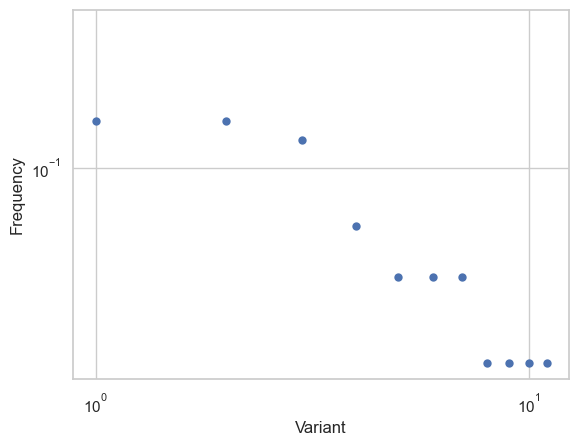

In [10]:
# Sort the variants frequency
freq = ocel.variant_frequencies.copy()
# Plot the frequency of the variants with seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x=list(range(len(freq))), y=freq)
ax.set(xlabel='Variant', ylabel='Frequency')
# Set both axes to log scale
ax.set_yscale('log')
ax.set_xscale('log')
# Do not outline the points
ax.collections[0].set_edgecolor("#00000000")
# Save the plot
plt.savefig(os.path.join(visualization_path, 'variant_frequency.png'))